In [50]:
import sys, os
import random
import numpy as np
from glob import glob
import pandas as pd
import kaldiio
import torch


random.seed(1)

print(torch.version)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

in_set = ['ENG', 'GER', 'ICE', 'FRE', 'SPA', 'ARA', 'RUS', 'BEN', 'KAS', 'GRE', 'CAT', 'KOR', 'TUR', 'TAM', 'TEL', 'CHI', 'TIB', 'JAV', 'EWE', 'HAU', 'LIN', 'YOR', 'HUN', 'HAW', 'MAO', 'ITA', 'URD', 'SWE', 'PUS', 'GEO', 'HIN', 'THA']
out_of_set = ['DUT', 'HEB', 'UKR', 'BUL', 'PER', 'ALB', 'UIG', 'MAL', 'BUR', 'IBA', 'ASA', 'AKU', 'ARM', 'HRV', 'FIN', 'JPN', 'NOR', 'NEP', 'RUM']

langs = in_set + out_of_set

num_in_set = 32

in_set = langs[:num_in_set]
out_of_set = langs[num_in_set:]

root_dir = "/home/sp4013/kaldi-trunk/egs/lid/s1/db/cu-multilang-dataset/"


assert(len(in_set) + len(out_of_set) == 51)
assert(len(set(in_set).intersection(set(out_of_set))) == 0)
for lang in os.listdir(root_dir):
    assert(lang in in_set or lang in out_of_set)

print("\n-----Getting Train/Test Data-----\n")

train, test = [], []
max_sample_length = 200

for i,lang in enumerate(in_set, 0):
    print(lang, "(In-set)" if lang in in_set else "(Out-of-set)")
    filepath = root_dir + lang + '/data/raw_mfcc_pitch_' + lang + '.1.ark'

    chunks = []
    count = 0
    for key, numpy_array in kaldiio.load_ark(filepath):
        count += 1
        chunks +=  np.split(numpy_array, np.arange(max_sample_length, len(numpy_array), max_sample_length))[:-1]
    random.shuffle(chunks)

    # Put chunks in train or test depending on in_set or out_of_set
    switch_point = 0.85 if lang in in_set else 0.0
    for j in range(len(chunks)):
        chunk = chunks[j]
        inputs = torch.from_numpy(np.expand_dims(chunk, axis=0))
        inputs.to(device)
        labels = torch.from_numpy(np.array([i if lang in in_set else -1]))
        labels.to(device)

        if j+1 <= switch_point * len(chunks):
            train.append((inputs, labels))
        else:
            test.append((inputs, labels))

print()
print("Num chunks in training:", len(train))
print("Num chunks in testing:", len(test))

print("\n-----Finished Data Splitting-----\n")

<module 'torch.version' from '/home/sp4013/anaconda3/lib/python3.9/site-packages/torch/version.py'>
cuda:0

-----Getting Train/Test Data-----

ENG (In-set)
GER (In-set)
ICE (In-set)
FRE (In-set)
SPA (In-set)
ARA (In-set)
RUS (In-set)
BEN (In-set)
KAS (In-set)
GRE (In-set)
CAT (In-set)
KOR (In-set)
TUR (In-set)
TAM (In-set)
TEL (In-set)
CHI (In-set)
TIB (In-set)
JAV (In-set)
EWE (In-set)
HAU (In-set)
LIN (In-set)
YOR (In-set)
HUN (In-set)
HAW (In-set)
MAO (In-set)
ITA (In-set)
URD (In-set)
SWE (In-set)
PUS (In-set)
GEO (In-set)
HIN (In-set)
THA (In-set)

Num chunks in training: 12324
Num chunks in testing: 2190

-----Finished Data Splitting-----



In [42]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from tdnn import TDNN
from pytorch_model_summary import summary


class Net(nn.Module):
    def __init__(self, in_size, num_classes):
        super().__init__()
        
        self.layer1 = TDNN(input_dim=in_size, output_dim=256, context_size=3)
        self.layer2 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer3 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer4 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.layer5 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.final_layer = TDNN(input_dim=256, output_dim=num_classes, context_size=1)
        
    def forward(self, x):
        forward_pass = nn.Sequential(
            self.layer1,
            nn.ReLU(),
            self.layer2,
            nn.ReLU(),
            self.layer3,
            nn.ReLU(),
            self.layer4,
            nn.ReLU(),
            self.layer5,
            nn.ReLU(),
            self.final_layer,
            nn.Softmax(dim=2))
        
        return forward_pass(x)
    
print(summary(Net(16, len(in_set)), torch.zeros((1, 258, 16)), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
            TDNN-1       [1, 256, 256]          13,056          13,056
            TDNN-2       [1, 254, 256]         197,376         197,376
            TDNN-3       [1, 252, 256]         197,376         197,376
            TDNN-4       [1, 252, 256]          66,304          66,304
            TDNN-5       [1, 252, 256]          66,304          66,304
            TDNN-6        [1, 252, 32]           8,288           8,288
Total params: 548,704
Trainable params: 548,704
Non-trainable params: 0
-----------------------------------------------------------------------


In [43]:
# net = Net(16, len(in_set))
# net.to(device)
# criterion = nn.CrossEntropyLoss() # a common loss function for multi-class classification problems
# optimizer = optim.SGD(net.parameters(), lr=0.001) # a common optimizer for multi-class classification problems

# # Train the TDNN network
# do_training = True # whether to train or to load a saved model
# SAVE_PATH = 'saved_models/tdnn.pth'
# LOAD_PATH = 'saved_models/tdnn.pth'

# if do_training:
#     print('Started Training')

#     for epoch in range(12):  # number of epochs
#         random.shuffle(train) # shuffle data every epoch
#         print('\tepoch: ', str(epoch + 1))
#         running_loss = 0.0
#         for i, data in enumerate(train, 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()

#             outputs = net(inputs) # pass inputs thorugh the model
# #             print(outputs[0])
#             outputs = torch.mean(outputs, 1) #average over all time slices
#             loss = criterion(outputs, labels) # compute loss
#             loss.backward() # compute gradients

# #             for name, param in net.named_parameters():
# #                 print(name, param.grad)
            
#             optimizer.step() # SGD step

#             running_loss += loss.item()
            
#         print("epoch " + str(epoch + 1) + ": " + str(running_loss / len(train)))

#     print('Finished Training')
#     torch.save(net.state_dict(), SAVE_PATH) # Save the model

In [44]:
def create_batches(data, batch_size=64):
    len_data = len(data)
    num_batches = (len_data // batch_size) + 1

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len_data - 1)

        yield data[start_idx: end_idx]



In [45]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train_model(model, loader, optimizer, criterion, device=None):
    train_loss = 0.0
    train_acc = 0.0
    num_batches = 0

    model.train()

    for batch in loader:
        num_batches += 1
        len_batch = len(batch)
        optimizer.zero_grad()
        loss = 0.0
        acc = 0.0
        for x, y in batch:
          # Send to GPU if available
          if device is not None:
            x = x.to(device)
            y = y.to(device)

          y_pred = model(x)
          y_pred = torch.mean(y_pred, 1)
          loss += criterion(y_pred, y)
          acc += calculate_accuracy(y_pred, y)
        
        loss /= len_batch
        acc /= len_batch
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    return train_loss / num_batches, train_acc / num_batches


def evaluate_model(model, loader, criterion, device=None):
    val_loss = 0.0
    val_acc = 0.0
    num_batches = 0

#     model.eval()
    with torch.no_grad():
        for batch in loader:
            num_batches += 1
            len_batch = len(batch)
            loss = 0.0
            acc = 0.0

            for x, y in batch:
              # Send to GPU if available
              if device is not None:
                x = x.to(device)
                y = y.to(device)

              y_pred = model(x)
              y_pred = torch.mean(y_pred, 1)
              loss += criterion(y_pred, y)
              acc += calculate_accuracy(y_pred, y)

            loss /= len_batch
            acc /= len_batch

            val_loss += loss.item()
            val_acc += acc.item()

    return val_loss / num_batches, val_acc / num_batches


In [51]:
# Initialize the TDNN, loss, and optimizer
# print(len(in_set))
net = Net(16, len(in_set))
net.to(device)
criterion = nn.CrossEntropyLoss() # a common loss function for multi-class classification problems
optimizer = optim.Adam(net.parameters(), lr=0.001) # a common optimizer for multi-class classification problems


# Train the TDNN network
do_training = True # whether to train or to load a saved model
SAVE_PATH = 'saved_models/tdnn.pth'
LOAD_PATH = 'saved_models/tdnn.pth'

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_loss = float('inf')
best_epoch = 0

if do_training:
    print('Started Training')

    for epoch in range(40):  # number of epochs
        random.shuffle(train) # shuffle data every epoch
        train_loss, train_accuracy = train_model(net, create_batches(train, batch_size=64), optimizer, criterion, device)
        val_loss, val_accuracy = evaluate_model(net, create_batches(test, batch_size=64), criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_loss:
          best_loss = val_loss
          best_epoch = epoch
          torch.save(net.state_dict(), SAVE_PATH) # Save the model


        print("Epoch: " + str(epoch) + ", Train Loss: " + str(train_loss) + ", Train Accuracy: " + str(train_accuracy) + \
            ", Val Loss: " + str(val_loss) + ", Val Accuracy: " + str(val_accuracy))


    print("Best Val Loss: " + str(best_loss) + " at Epoch: " + str(best_epoch))
                
    print('Finished Training')
    

Started Training
Epoch: 0, Train Loss: 3.4561789307569595, Train Accuracy: 0.15917607331214173, Val Loss: 3.4486708300454274, Val Accuracy: 0.26964285714285713
Epoch: 1, Train Loss: 3.440697567450568, Train Accuracy: 0.35043717619668635, Val Loss: 3.4329835414886474, Val Accuracy: 0.38526785714285716
Epoch: 2, Train Loss: 3.4237793480176384, Train Accuracy: 0.43938286455801734, Val Loss: 3.4154320921216694, Val Accuracy: 0.45714285714285713
Epoch: 3, Train Loss: 3.405185070680213, Train Accuracy: 0.49353025537080714, Val Loss: 3.3973328794751847, Val Accuracy: 0.4856456045593534
Epoch: 4, Train Loss: 3.3834293493952776, Train Accuracy: 0.5268157847187062, Val Loss: 3.3717357431139265, Val Accuracy: 0.5490041213376181
Epoch: 5, Train Loss: 3.354284828808641, Train Accuracy: 0.5699273687570207, Val Loss: 3.3385729108537947, Val Accuracy: 0.5760989018848964
Epoch: 6, Train Loss: 3.3196404857339017, Train Accuracy: 0.6084497595698105, Val Loss: 3.302753325871059, Val Accuracy: 0.6145260998

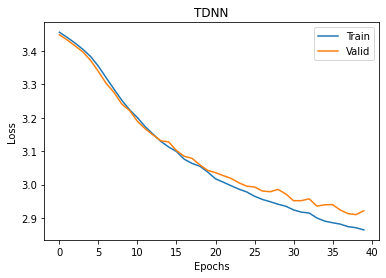

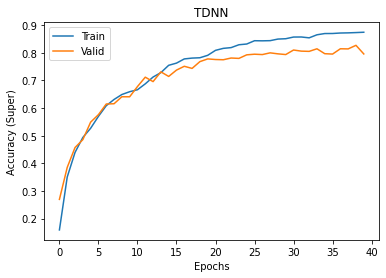

In [52]:
import matplotlib.pyplot as plt


model_name = "TDNN"
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(model_name)

res_path = os.path.join("./", "results", str(max_sample_length))
os.makedirs(res_path, exist_ok=True)
plt.savefig(os.path.join(res_path, "loss_plot"))

plt.show()

plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Super)")
plt.legend()
plt.title(model_name)

res_path = os.path.join("./", "results", str(max_sample_length))
os.makedirs(res_path, exist_ok=True)
plt.savefig(os.path.join(res_path, "accuracy_plot"))

plt.show()

In [53]:
# Add out of set to test set

for i,lang in enumerate(out_of_set, 0):
    print(lang, "(In-set)" if lang in in_set else "(Out-of-set)")
    filepath = root_dir + lang + '/data/raw_mfcc_pitch_' + lang + '.1.ark'

    chunks = []
    for key, numpy_array in kaldiio.load_ark(filepath):
        chunks +=  np.split(numpy_array, np.arange(max_sample_length, len(numpy_array), max_sample_length))[:-1]
    random.shuffle(chunks)

    for j in range(len(chunks)):
        chunk = chunks[j]
        inputs = torch.from_numpy(np.expand_dims(chunk, axis=0))
        inputs.to(device)
        labels = torch.from_numpy(np.array([i if lang in in_set else -1]))
        labels.to(device)

        test.append((inputs,labels))
        
print(len(test))

DUT (Out-of-set)
HEB (Out-of-set)
UKR (Out-of-set)
BUL (Out-of-set)
PER (Out-of-set)
ALB (Out-of-set)
UIG (Out-of-set)
MAL (Out-of-set)
BUR (Out-of-set)
IBA (Out-of-set)
ASA (Out-of-set)
AKU (Out-of-set)
ARM (Out-of-set)
HRV (Out-of-set)
FIN (Out-of-set)
JPN (Out-of-set)
NOR (Out-of-set)
NEP (Out-of-set)
RUM (Out-of-set)
8078


In [ ]:
net.load_state_dict(torch.load(LOAD_PATH))

for thresh in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    correct = 0
    for x, y in test:
      # Send to GPU if available
      if device is not None:
        x = x.to(device)
        y = y.to(device)

      y_pred = net(x)
      y_pred = torch.mean(y_pred, 1)
      conf = y_pred.amax(1, keepdim=True)

      if conf > thresh:
          top_pred = y_pred.argmax(1, keepdim=True)
      else:
          top_pred = -1

      if top_pred == y:
        correct += 1
        
    print(thresh, correct / len(test))
    


0.2 0.37546422381777667
0.3 0.4592720970537262
0.4 0.522035157217133
